In [65]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, Normalizer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import catboost as cb
from xgboost import XGBRegressor, XGBClassifier
import itertools
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
def my_data_transformer(X, scaler_minmax_to_use=np.nan, scaler_normalize_to_use=np.nan, scaler_minmax_for_cross_to_use=np.nan, scaler_standard_for_pca_to_use=np.nan, pca_to_use=np.nan):
    X_copy = X.copy()
    
    # 1. Временно убираем категориальный признак 
    X_cover_angle = pd.DataFrame(X_copy.pop('cover_angle'))
    
    # 2. Приводим к единому масштабу данных - [0, 1] - через MinMaxScaler
    scaler_minmax = scaler_minmax_to_use if scaler_minmax_to_use is not np.nan else MinMaxScaler().fit(X_copy)
    X_scaled = pd.DataFrame(scaler_minmax.transform(X_copy), index=X_copy.index, columns=X_copy.columns.tolist())
    
    # 3. Создание новых признаков: Нормализуем по строкам (по наблюдениям = горизонтально), а не по признакам (вертикально), т.к. по признакам корреляция с целевой переменной незначительная
    scaler_normalize = scaler_normalize_to_use if scaler_normalize_to_use is not np.nan else Normalizer().fit(X_copy)
    X_norm = pd.DataFrame(scaler_normalize.transform(X_copy), index=X_copy.index, columns=[f'{col}_norm' for col in X_copy.columns.tolist()])    
    
    # 4. Создание новых признаков: попарное перемножение 
    col_names = X_copy.columns.tolist()
    col_pair_combinations = list(itertools.combinations(col_names, 2))
    X_cross = []
    for col_pair in col_pair_combinations:
        X_cross.append(X_copy.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    X_cross = pd.DataFrame(X_cross).T
    X_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]
    # Нормализуем получившиеся значения - приводим к масштабу данных в диапазоне [0-1]
    scaler_minmax_for_cross = scaler_minmax_for_cross_to_use if scaler_minmax_for_cross_to_use is not np.nan else MinMaxScaler().fit(X_cross)
    X_cross_scaled = pd.DataFrame(scaler_minmax_for_cross.transform(X_cross), index=X_copy.index, columns=X_cross.columns.tolist())          
        
    # 5. Создание новых признаков: главные компоненты (PCA)
    scaler_standard_for_pca = scaler_standard_for_pca_to_use if scaler_standard_for_pca_to_use is not np.nan else StandardScaler().fit(X_copy)
    X_stand = scaler_standard_for_pca.transform(X_copy)
    pca = pca_to_use if pca_to_use is not np.nan else PCA(random_state=42).fit(X_stand)
    X_pca = pd.DataFrame(pca.transform(X_stand), index=X_copy.index, columns=[f'PC_{i + 1}' for i in np.arange(X_stand.shape[1])])
    # plt.figure(figsize=(20, 6))
    # sns.barplot(x=X_pca.columns, y=pca.explained_variance_ratio_);
    
    # Собираем все признаки в один датасет, включая ранее временно исключенный категориальный
    X_to_use = pd.concat([X_scaled, X_norm, X_cross_scaled, X_pca, X_cover_angle], axis=1).reset_index(drop=True)
    
    return X_to_use      
        

# Выбор наилучшего метода для задачи на целевую переменную 'Прочность при растяжении' (solidity_on_stretching)

### Загружаем подготовленные данные

In [67]:
data_solidity = pd.read_csv('../../data/data_for_model/solidity_on_stretching_data_to_use.csv', sep=';', index_col=[0])
data_solidity

,solidity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
0,2587.342983,2.587348,1953.274926,137.627420,22.344534,234.716883,246.613117,1,4.000000,468.670776,85.631671,145.526898
1,2624.026407,2.046471,2037.631811,101.617251,23.146393,312.307205,178.198556,1,5.000000,312.793361,84.805005,113.632918
2,2473.187195,1.856476,2018.220332,135.401697,26.435515,327.510377,123.344561,1,5.000000,360.746332,36.659075,120.868161
3,3059.032991,3.305535,1917.907506,105.786930,17.874100,328.154579,275.575880,1,5.000000,223.892990,82.700017,145.526898
4,2288.967377,2.709554,1892.071124,96.563293,22.989291,262.956722,126.816339,1,7.000000,287.514837,108.667505,90.114645
...,...,...,...,...,...,...,...,...,...,...,...,...
921,2387.292495,2.271346,1952.087902,86.992183,20.123249,324.774576,125.007669,1,9.076380,388.740128,45.403985,90.160173
922,2360.392784,3.444022,2050.089171,145.981978,19.599769,254.215401,117.730099,1,10.565614,210.404942,63.557294,105.887238
923,2662.906040,3.280604,1972.372865,110.533477,23.957502,248.423047,236.606764,1,4.161154,199.076146,102.983095,139.609893
924,2071.715856,3.705351,2066.799773,141.397963,19.246945,275.779840,197.126067,1,6.313201,325.540723,93.916114,116.664723


In [68]:
data_solidity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926 entries, 0 to 925
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   solidity_on_stretching  926 non-null    float64
 1   matrix_filler_ratio     926 non-null    float64
 2   density                 926 non-null    float64
 3   hardener                926 non-null    float64
 4   epoxid                  926 non-null    float64
 5   temperature             926 non-null    float64
 6   resin                   926 non-null    float64
 7   cover_angle             926 non-null    int64  
 8   cover_step              926 non-null    float64
 9   elasticity_boxcox       926 non-null    float64
 10  surface_density_boxcox  926 non-null    float64
 11  cover_strength_boxcox   926 non-null    float64
dtypes: float64(11), int64(1)
memory usage: 94.0 KB


In [69]:
data_solidity.describe()

,solidity_on_stretching,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
count,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000
mean,2461.897783,2.928785,1973.665780,110.563651,22.232822,285.552337,217.858664,0.515119,6.908695,319.581408,74.757641,114.936179
std,459.039705,0.895414,70.712897,27.289196,2.420989,39.801028,57.492625,0.500041,2.521220,125.422330,31.024925,27.437016
min,1250.392802,0.547391,1784.482245,35.599697,15.695894,179.374391,63.685698,0.000000,0.037639,2.185759,0.550804,42.058229
25%,2148.175736,2.320191,1923.521521,92.054117,20.552676,258.469516,179.719792,0.000000,5.154793,231.861300,53.495200,97.305281
50%,2457.959767,2.906630,1977.119592,110.438871,22.200872,285.386175,216.779521,1.000000,6.933594,322.911894,75.808235,114.916900
75%,2751.233766,3.549367,2019.842447,130.404874,23.994431,313.158048,256.995883,1.000000,8.585790,406.758999,99.007876,132.600258
max,3660.450210,5.314144,2161.565216,181.828448,28.955094,386.067992,359.052220,1.000000,13.732404,643.825211,155.040900,186.566543


### Переводим задачу регрессии в задачу классификации - присваиваем целевой переменной лейблы (классы)

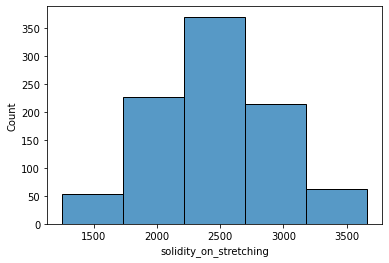

In [70]:
n_bins = 5
sns.histplot(data_solidity['solidity_on_stretching'], bins=n_bins);

In [71]:
counts, binEdges = np.histogram(data_solidity['solidity_on_stretching'], bins=n_bins)

In [72]:
counts

array([ 53, 226, 370, 215,  62], dtype=int64)

In [73]:
binEdges

array([1250.39280221, 1732.40428373, 2214.41576525, 2696.42724677,
       3178.4387283 , 3660.45020982])

In [74]:
data_solidity['label'] = np.digitize(data_solidity['solidity_on_stretching'], binEdges, right=False).ravel()

In [75]:
data_solidity.loc[data_solidity['solidity_on_stretching'].argmax(), 'label'] = n_bins

In [76]:
# Делаем отсчёт лейблов с 0 (т.к. это требование большинства алгоритмов) 
data_solidity['label'] = data_solidity['label'] - 1

In [77]:
classes_values = data_solidity.groupby('label')[['solidity_on_stretching']].mean()
classes_values.to_csv('../../app/model_to_use/solidity_on_stretching_aver_values.csv', index=True)
classes_values

,solidity_on_stretching
label,
0,1556.523288
1,2019.512065
2,2460.258213
3,2889.653099
4,3374.853731


In [78]:
solidity_on_stratching_avel_values = pd.read_csv('../../app/model_to_use/solidity_on_stretching_aver_values.csv', index_col=[0])['solidity_on_stretching'].to_dict()
solidity_on_stratching_avel_values[0]

1556.5232884462189

In [79]:
# Удаляем столбец с исходными значениями целевой переменной, оставляя только labels классов
data_solidity = data_solidity.drop(columns=['solidity_on_stretching'])
data_solidity

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,label
0,2.587348,1953.274926,137.627420,22.344534,234.716883,246.613117,1,4.000000,468.670776,85.631671,145.526898,2
1,2.046471,2037.631811,101.617251,23.146393,312.307205,178.198556,1,5.000000,312.793361,84.805005,113.632918,2
2,1.856476,2018.220332,135.401697,26.435515,327.510377,123.344561,1,5.000000,360.746332,36.659075,120.868161,2
3,3.305535,1917.907506,105.786930,17.874100,328.154579,275.575880,1,5.000000,223.892990,82.700017,145.526898,3
4,2.709554,1892.071124,96.563293,22.989291,262.956722,126.816339,1,7.000000,287.514837,108.667505,90.114645,2
...,...,...,...,...,...,...,...,...,...,...,...,...
921,2.271346,1952.087902,86.992183,20.123249,324.774576,125.007669,1,9.076380,388.740128,45.403985,90.160173,2
922,3.444022,2050.089171,145.981978,19.599769,254.215401,117.730099,1,10.565614,210.404942,63.557294,105.887238,2
923,3.280604,1972.372865,110.533477,23.957502,248.423047,236.606764,1,4.161154,199.076146,102.983095,139.609893,2
924,3.705351,2066.799773,141.397963,19.246945,275.779840,197.126067,1,6.313201,325.540723,93.916114,116.664723,1


In [80]:
count_samples_by_labels = data_solidity['label'].value_counts().sort_index()
count_samples_by_labels

0     53
1    226
2    370
3    215
4     62
Name: label, dtype: int64

### Исправляем дисбаланс классов

In [81]:
label_max_count = count_samples_by_labels.max()
labels_coeff_for_oversampl = []

for i in np.arange(n_bins):
    labels_coeff_for_oversampl.append(label_max_count//count_samples_by_labels[i])
    
labels_coeff_for_oversampl

[6, 1, 1, 1, 5]

In [82]:
def fix_undersampling(data, label, max_count):
    label_df = data.loc[data['label'] == label, :]
    init_count = label_df.shape[0]
    new_df = pd.DataFrame()
    while new_df.shape[0] < max_count:    
        current_count = new_df.shape[0]
        sample_size = np.min([init_count, (max_count - current_count)])
        subset = label_df.sample(sample_size)
        new_df = pd.concat([new_df, subset], axis=0)
    new_df = new_df.reset_index(drop=True)
    return new_df

In [83]:
data_solidity_to_use = pd.DataFrame()

for i in np.arange(n_bins):
    data_solidity_to_use = pd.concat([data_solidity_to_use, fix_undersampling(data_solidity, i, label_max_count)], axis=0).reset_index(drop=True)
    
data_solidity_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,label
0,3.355421,1995.549153,110.738213,24.696093,193.431144,280.880603,1,7.933368,414.708614,105.864438,89.986538,0
1,2.571758,2066.355044,170.332558,26.546042,246.027954,190.242138,1,8.237030,211.480433,111.700796,89.140278,0
2,0.827016,1920.051313,106.790625,21.203769,270.244342,188.628413,1,6.231992,330.027925,52.387887,119.025531,0
3,4.315666,1913.379677,143.576937,24.275588,274.988794,248.244330,0,7.656211,355.817479,52.437680,60.201728,0
4,2.770720,1887.288244,122.378495,24.520994,306.206028,180.644374,1,8.244370,488.206285,96.443192,95.309292,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1845,2.031785,1953.102734,135.606635,19.781174,295.852961,186.783814,0,9.475852,102.198278,91.869302,172.157997,4
1846,4.235150,1896.989715,99.289584,20.660267,319.489833,273.869926,1,3.982204,287.151009,124.792417,97.707350,4
1847,4.132379,2006.339130,85.631079,23.636298,289.566252,208.279613,1,8.285425,488.194519,125.828083,120.940463,4
1848,0.998971,2003.841846,157.818752,20.350601,261.670290,182.599404,1,7.219647,233.143902,119.123504,123.248540,4


In [84]:
data_solidity_to_use['label'].value_counts()

0    370
1    370
2    370
3    370
4    370
Name: label, dtype: int64

### На всякий случай принудительно производим случайное перемешивание по строкам

In [85]:
data_solidity_to_use = data_solidity_to_use.sample(frac=1, random_state=42).reset_index(drop=True)
data_solidity_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,label
0,3.725152,2009.398720,148.316386,16.869670,289.236170,172.549269,0,5.182935,406.803680,69.098072,169.696018,0
1,2.906383,2013.083059,108.013185,22.370657,258.991905,298.092880,0,7.181308,416.253467,13.165216,97.882112,4
2,3.106634,1884.734983,160.433234,26.809241,354.325741,275.412755,1,6.544660,257.570335,50.416738,100.536282,1
3,3.289360,2061.014479,121.066050,20.981730,307.840838,252.988512,0,4.003623,181.521167,43.746780,63.890637,2
4,1.647649,2110.985588,101.935506,19.462720,242.918105,172.013665,1,5.860357,21.650154,98.331228,125.468461,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1845,2.793557,2018.902014,78.599934,20.559280,316.694669,147.566245,0,7.407166,354.956578,110.159607,127.705930,3
1846,2.558728,1997.133949,44.302222,21.557154,283.102710,175.016320,1,4.395254,304.862271,117.139687,90.213359,3
1847,3.424994,1970.499475,144.625151,24.652291,264.988059,242.723169,1,5.959359,403.944945,98.855913,95.342858,2
1848,2.365193,1934.309403,97.490504,26.820442,229.940794,224.773830,0,9.349435,263.948702,22.956342,68.266807,3


### Делим датасет на train и test

In [86]:
y = data_solidity_to_use[['label']]
X = data_solidity_to_use.drop(columns=['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y.values.ravel(), random_state=42)

In [87]:
X_train.describe()

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
count,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000,1295.000000
mean,2.935245,1971.431088,111.069562,22.168355,286.485330,215.039881,0.518147,7.007074,319.843499,75.109984,114.469526
std,0.882701,72.650507,28.429405,2.450617,38.607326,59.128028,0.499864,2.484259,126.893295,31.483550,27.796610
min,0.547391,1784.482245,35.599697,15.695894,179.374391,63.685698,0.000000,0.037639,3.714979,0.550804,42.058229
25%,2.386868,1922.309484,91.493812,20.512314,260.616588,175.767919,0.000000,5.204978,230.942990,53.904970,96.832004
50%,2.918289,1974.917774,110.860146,22.181806,285.407901,210.710993,1.000000,7.068781,324.861977,76.325017,113.859961
75%,3.500687,2019.601135,131.672109,23.919536,313.061676,256.479886,1.000000,8.682344,410.355062,99.326021,131.994780
max,5.314144,2161.565216,181.032809,28.955094,386.067992,359.052220,1.000000,13.653987,643.825211,155.040900,186.566543


In [88]:
X_test.describe()

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_angle,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,2.909106,1975.424862,110.069778,22.235672,285.534525,219.662699,0.513514,6.876138,318.523967,73.892524,115.682087
std,0.904314,70.723793,27.614111,2.316067,39.444484,57.794921,0.500268,2.438117,133.267747,32.614000,27.258255
min,0.596783,1804.840230,40.304806,15.695894,187.562353,63.685698,0.000000,0.239660,2.185759,0.550804,45.685421
25%,2.297477,1927.984542,91.218699,20.616439,259.356187,180.647272,0.000000,5.167349,218.809115,50.938726,97.194649
50%,2.864568,1977.339047,110.457519,22.329712,286.139430,220.185711,1.000000,6.851316,324.085398,76.155152,115.081495
75%,3.522958,2019.653595,131.151729,23.961468,315.977655,257.768388,1.000000,8.489268,414.708614,98.468208,133.117138
max,5.295842,2150.337595,181.828448,28.955094,385.894771,359.052220,1.000000,13.732404,643.825211,147.052951,186.566543


In [89]:
# X_train_to_use = my_data_transformer(X_train)
# X_train_to_use

### Временно убираем категориальный признак из основного датасета и сохраняем в отдельной переменной

In [90]:
cover_angle_train = pd.DataFrame(X_train.pop('cover_angle'))
cover_angle_test = pd.DataFrame(X_test.pop('cover_angle'))

# Осуществляем разные транформации признаков

### Нормализуем X_train
### Сначала нормализуем через MinMaxScaler (приводим значения к единому масштабу)
### Далее... Т.к. корреляция признаков с целевой переменной практически отсутствует (feature-wise), то предполагаем, что более значимым может быть взаимосвязь целевой переменной с разным набором признаков, взятых как единое целое (рецептура), т.е. по горизонтали (sample-wise). Для этого ещё дополнительно нормализуем по горизонтали через Normalizer()

In [91]:
# Приводим к единому масштабу данных от 0 до 1
scaler_minmax = MinMaxScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler_minmax.transform(X_train), index=X_train.index, columns=X_train.columns.tolist())

# Сохраняем Scaler (для дальнейшего использования в релизе модели)
pickle.dump(scaler_minmax, open('../../app/model_to_use/scaler_minmax_for_solidity_model.pkl', 'wb'))

In [92]:
# Нормализуем по строкам (по наблюдениям = горизонтально), а не по признакам (вертикально), т.к. по признакам корреляция с целевой переменной незначительная
scaler_normalize = Normalizer().fit(X_train)
X_train_norm = pd.DataFrame(scaler_normalize.transform(X_train), index=X_train.index, columns=[f'{col}_norm' for col in X_train.columns.tolist()])

# Сохраняем Scaler (для дальнейшего использования в релизе модели)
pickle.dump(scaler_normalize, open('../../app/model_to_use/scaler_normalize_for_solidity_model.pkl', 'wb'))

### Попарное перемножение признаков

In [93]:
col_names = X_train.columns.tolist()
col_pair_combinations = list(itertools.combinations(col_names, 2))

X_train_cross = []

for col_pair in col_pair_combinations:
    X_train_cross.append(X_train.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    
X_train_cross = pd.DataFrame(X_train_cross).T
X_train_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]

# Нормализуем получившиеся значения - приводим к масштабу данных в диапазоне [0-1]
scaler_minmax_for_cross = MinMaxScaler().fit(X_train_cross)
X_train_cross_scaled = pd.DataFrame(scaler_minmax_for_cross.transform(X_train_cross), index=X_train.index, columns=X_train_cross.columns.tolist())

# Сохраняем Scaler (для дальнейшего использования в релизе модели)
pickle.dump(scaler_minmax_for_cross, open('../../app/model_to_use/scaler_minmax_for_cross_for_solidity_model.pkl', 'wb'))

### Создаём новые признаки через Метод Главных Компонент (PCA)

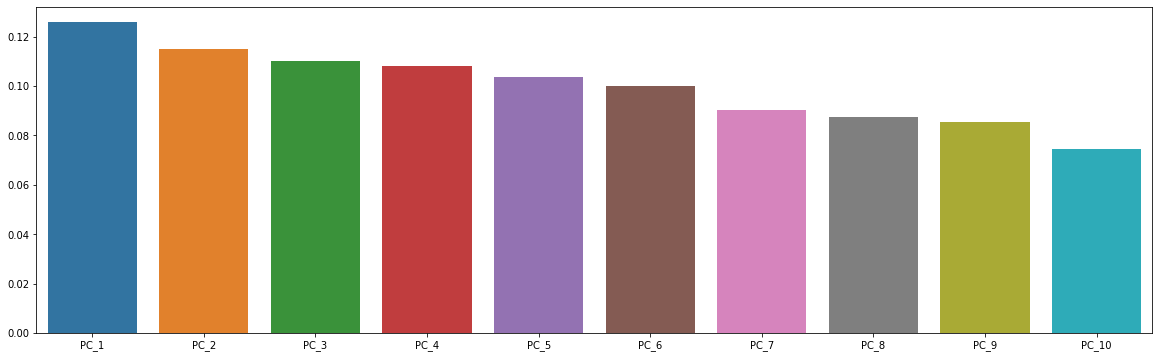

In [94]:
scaler_standard_for_pca = StandardScaler().fit(X_train)
X_train_standard = scaler_standard_for_pca.transform(X_train)

pca = PCA(random_state=42).fit(X_train_standard)
X_train_pca = pd.DataFrame(pca.transform(X_train_standard), index=X_train.index, columns=[f'PC_{i + 1}' for i in np.arange(X_train_standard.shape[1])])

plt.figure(figsize=(20, 6))
sns.barplot(x=X_train_pca.columns, y=pca.explained_variance_ratio_);

# Сохраняем Scaler (для дальнейшего использования в релизе модели)
pickle.dump(scaler_standard_for_pca, open('../../app/model_to_use/scaler_standard_for_pca_for_solidity_model.pkl', 'wb'))

# Сохраняем PCA (для дальнейшего использования в релизе модели)
pickle.dump(pca, open('../../app/model_to_use/pca_for_solidity_model.pkl', 'wb'))

# X_train to use

In [95]:
X_train_to_use = pd.concat([X_train_scaled, X_train_norm, X_train_cross_scaled, X_train_pca, cover_angle_train], axis=1).reset_index(drop=True)
X_train_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,...,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,cover_angle
0,0.104988,0.481751,0.192890,0.816080,0.500557,0.672601,0.926742,0.452436,0.710969,0.536554,...,2.738148,0.209864,-0.443379,-0.380556,-2.068563,-0.544197,1.091924,1.132999,-0.839105,1
1,0.292289,0.502237,0.603089,0.518144,0.540190,0.619229,0.727114,0.180608,0.613049,0.316886,...,1.691975,1.185755,-0.903467,0.843577,-0.641616,-0.176958,-0.800579,0.221378,0.152236,0
2,0.713926,0.334541,0.806018,0.500585,0.273670,0.684409,0.431121,0.478921,0.225445,0.477879,...,-0.522865,-0.458567,0.579453,-0.036788,1.587850,0.073651,-1.753126,1.287733,-0.078249,0
3,0.364071,0.593703,0.782306,0.449941,0.731151,0.668293,0.511324,0.290559,0.537424,0.495298,...,0.457549,0.398313,-1.283551,1.373520,-0.231987,1.103270,-0.480485,-0.046643,-0.038644,1
4,0.112867,0.162449,0.411017,0.273316,0.647386,0.379468,0.516375,0.464550,0.596314,0.622362,...,0.235542,0.665321,0.982166,1.200782,-1.886921,-0.766149,0.564467,-0.692798,-1.338833,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,0.337182,0.611793,0.596805,0.677823,0.445221,0.457253,0.237313,0.432581,0.285543,0.664899,...,-0.759649,0.270520,0.749158,0.687183,0.490006,1.539223,0.143503,0.397849,-0.915345,1
1291,0.171071,0.284121,0.470303,0.488826,0.487439,0.778510,0.642602,0.795303,0.368086,0.378164,...,1.016984,0.160970,0.914080,0.414307,-0.688774,-0.446969,1.130208,2.106108,-0.074465,1
1292,0.573227,0.353473,0.693765,0.357420,0.444761,0.531551,0.516695,0.319421,0.559493,0.419606,...,-0.071269,0.504249,-0.343980,0.373926,0.315760,-0.649284,-1.329015,-0.165886,-0.127799,1
1293,0.621148,0.459848,0.630439,0.485250,0.627442,0.541194,0.463599,0.843329,0.393335,0.628569,...,-0.884810,-1.012990,0.174032,-0.772519,0.124868,0.730716,0.588531,0.426506,-0.032300,1


# Применяем все теже самые преобразования к X_test

In [96]:
# MinMax Re-scale (feature-wise)
X_test_scaled = pd.DataFrame(scaler_minmax.transform(X_test), index=X_test.index, columns=X_test.columns)

In [97]:
# Normalize (sample-wise)
X_test_norm = pd.DataFrame(scaler_normalize.transform(X_test), index=X_test.index, columns=[f'{col}_norm' for col in X_test.columns.tolist()])

In [98]:
# Multiply (cross-effects)

col_names = X_test.columns.tolist()
col_pair_combinations = list(itertools.combinations(col_names, 2))

X_test_cross = []

for col_pair in col_pair_combinations:
    X_test_cross.append(X_test.loc[:, col_pair].apply(lambda x: x[0] * x[1], axis=1))
    
X_test_cross = pd.DataFrame(X_test_cross).T
X_test_cross.columns = [f'{col_name[0]}_cross_{col_name[1]}' for col_name in col_pair_combinations]

X_test_cross_scaled = pd.DataFrame(scaler_minmax_for_cross.transform(X_test_cross), index=X_test_cross.index, columns=X_test_cross.columns.tolist())

In [99]:
# X_test_norm['all_mutiplied'] = X_test_norm.apply(lambda x: np.prod(x), axis=1)

In [100]:
# Apply PCA
X_test_standard = scaler_standard_for_pca.transform(X_test)
X_test_pca = pd.DataFrame(pca.transform(X_test_standard), index=X_test.index, columns=[f'PC_{i + 1}' for i in np.arange(X_test.shape[1])])

# X_test to use

In [101]:
X_test_to_use = pd.concat([X_test_scaled, X_test_norm, X_test_cross_scaled, X_test_pca, cover_angle_test], axis=1).reset_index(drop=True)
X_test_to_use

,matrix_filler_ratio,density,hardener,epoxid,temperature,resin,cover_step,elasticity_boxcox,surface_density_boxcox,cover_strength_boxcox,...,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,cover_angle
0,0.478775,0.423288,0.613853,0.485480,0.822457,0.391129,0.881855,0.714415,0.738015,0.582518,...,0.739799,-0.214796,-0.985526,-1.407124,-2.052867,0.356722,0.355646,-0.486856,0.020448,0
1,0.577263,0.462003,0.509108,0.578603,0.618106,0.505642,0.733629,0.354983,0.665084,0.589396,...,0.990711,-0.386197,-0.930841,-0.605285,-0.706553,-0.094726,-0.563748,-0.598898,-0.384018,1
2,0.627252,0.434727,0.043227,0.302071,0.298089,0.585117,0.334771,0.602157,0.444352,0.689439,...,-1.083947,-1.589507,1.099731,0.295971,0.367200,-2.021717,1.002776,-0.199396,-0.226057,0
3,0.818535,0.332347,0.200955,0.702621,0.315759,0.186653,0.439563,0.368590,0.581743,0.439101,...,0.153992,0.196917,0.868057,-1.913478,1.188287,-1.332501,-0.299072,-1.468439,-0.734654,1
4,0.450404,0.307533,0.054010,0.734721,0.431303,0.000000,0.585908,0.524276,0.451446,0.716625,...,0.401632,-0.083827,2.236923,-1.800421,-1.129361,-0.455630,0.727621,-1.427917,-1.283647,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,0.220833,0.368842,0.308295,0.387745,0.339568,0.346775,0.528705,0.581692,0.395421,0.892441,...,-0.841729,-0.580982,1.758706,0.401227,-1.945067,-0.474391,0.318263,0.228487,-1.128885,0
551,0.632164,0.401372,0.473974,0.570357,0.678266,0.364081,0.433177,0.901872,0.603894,0.584559,...,-0.783667,-0.480234,0.077212,-1.661050,-0.023204,0.240182,1.417341,-0.401330,-0.570017,1
552,0.441046,0.180703,0.575829,0.414314,0.487396,0.912838,0.574250,0.542755,0.897132,0.548720,...,0.525177,-0.296714,-1.528878,0.414551,-0.363144,-1.732461,0.027312,1.110549,-1.557821,1
553,0.589143,0.381133,0.259099,0.488878,0.217660,0.353409,0.450799,0.298734,0.353382,0.505721,...,-0.090271,0.006761,1.512843,-0.122835,0.575136,-1.262284,-0.719892,-0.486661,-0.223383,1


In [102]:
# scaler_minmax_to_use = pickle.load(open('../../app/model_to_use/scaler_minmax_for_elasticity_model.pkl', 'rb'))
# scaler_normalize_to_use = pickle.load(open('../../app/model_to_use/scaler_normalize_for_elasticity_model.pkl', 'rb'))
# scaler_minmax_for_cross_to_use = pickle.load(open('../../app/model_to_use/scaler_minmax_for_cross_for_elasticity_model.pkl', 'rb'))
# scaler_standard_for_pca_to_use = pickle.load(open('../../app/model_to_use/scaler_standard_for_pca_for_elasticity_model.pkl', 'rb'))
# pca_to_use = pickle.load(open('../../app/model_to_use/pca_for_elasticity_model.pkl', 'rb'))


# X_test_to_use = my_data_transformer(X_test, scaler_minmax_to_use, scaler_normalize_to_use, scaler_minmax_for_cross_to_use, scaler_standard_for_pca_to_use, pca_to_use)
# X_test_to_use

In [103]:
X_train_to_use.shape, X_test_to_use.shape

((1295, 76), (555, 76))

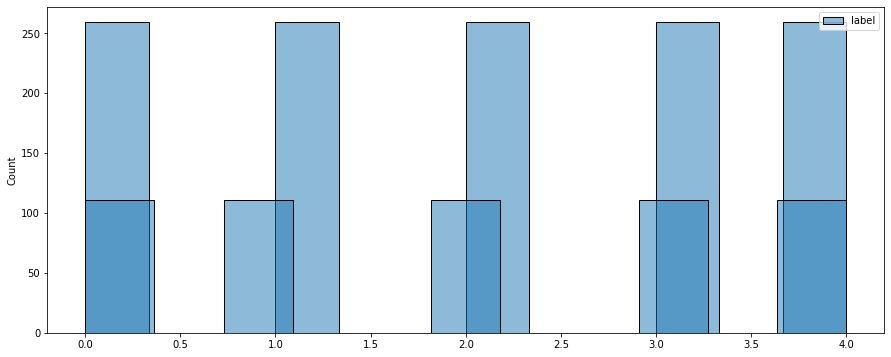

In [104]:
plt.figure(figsize=(15, 6))
sns.histplot(y_train)
sns.histplot(y_test);

# Fit and compare models

In [105]:
cv_to_use = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)
# score_to_use = make_scorer(f1_score, average='weighted')
score_to_use = make_scorer(accuracy_score)

### Model_1

In [106]:
# clf_xgb = XGBClassifier(objective='multi:softmax',
#                         n_jobs=-1,
#                         random_state=42)

# params_xgb = {'n_estimators': [1000, 1500],
#               'max_depth': [5, 7],
#               'learning_rate': [0.001, 0.01, 0.1]}

# gsearch_xgb = GridSearchCV(estimator=clf_xgb, param_grid=params_xgb, scoring=score_to_use, cv=cv_to_use)
# gsearch_xgb.fit(X_train_to_use, y_train.values.ravel())

# print(gsearch_xgb.best_score_)
# print(gsearch_xgb.best_params_)

In [107]:
# clf_xgb_to_use = gsearch_xgb.best_estimator_

In [108]:
clf_xgb = XGBClassifier(objective='multi:softmax',
                        n_estimators = 1500,
                        max_depth=5,
                        learning_rate=0.01,
                        n_jobs=-1,
                        random_state=42).fit(X_train_to_use, y_train.values.ravel())

In [109]:
y_train_pred = clf_xgb.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       259
           3       1.00      1.00      1.00       259
           4       1.00      1.00      1.00       259

    accuracy                           1.00      1295
   macro avg       1.00      1.00      1.00      1295
weighted avg       1.00      1.00      1.00      1295



In [110]:
y_test_pred = clf_xgb.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       112
           1       0.72      0.66      0.69       121
           2       0.36      0.51      0.42        79
           3       0.75      0.63      0.69       131
           4       0.95      0.94      0.94       112

    accuracy                           0.75       555
   macro avg       0.75      0.75      0.75       555
weighted avg       0.78      0.75      0.76       555



### Model_2

In [111]:
from sklearn.naive_bayes import GaussianNB
clf_gauss = GaussianNB().fit(X_train_to_use, y_train.values.ravel())

y_train_pred = clf_gauss.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       0.46      0.36      0.40       338
           1       0.16      0.34      0.22       122
           2       0.16      0.32      0.22       131
           3       0.49      0.32      0.39       395
           4       0.37      0.31      0.33       309

    accuracy                           0.33      1295
   macro avg       0.33      0.33      0.31      1295
weighted avg       0.39      0.33      0.34      1295



In [112]:
y_test_pred = clf_gauss.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.43      0.34      0.38       141
           1       0.14      0.41      0.21        39
           2       0.13      0.25      0.17        56
           3       0.42      0.26      0.32       184
           4       0.27      0.22      0.24       135

    accuracy                           0.28       555
   macro avg       0.28      0.30      0.26       555
weighted avg       0.34      0.28      0.29       555



### Model 3

In [113]:
from sklearn.ensemble import AdaBoostClassifier
clf_adab = AdaBoostClassifier(n_estimators=1000, random_state=42).fit(X_train_to_use, y_train.values.ravel())

y_train_pred = clf_adab.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       0.64      0.84      0.73       197
           1       0.61      0.43      0.50       368
           2       0.47      0.42      0.44       288
           3       0.49      0.45      0.47       280
           4       0.41      0.65      0.50       162

    accuracy                           0.52      1295
   macro avg       0.52      0.56      0.53      1295
weighted avg       0.53      0.52      0.52      1295



In [114]:
y_test_pred = clf_adab.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.64      0.86      0.73        83
           1       0.42      0.31      0.36       153
           2       0.32      0.25      0.28       145
           3       0.33      0.32      0.33       114
           4       0.33      0.62      0.43        60

    accuracy                           0.41       555
   macro avg       0.41      0.47      0.43       555
weighted avg       0.40      0.41      0.40       555



### Model 4

In [115]:
from sklearn.neighbors import KNeighborsClassifier
clf_neigh = KNeighborsClassifier(n_neighbors=3, n_jobs=-1).fit(X_train_to_use, y_train.values.ravel())

y_train_pred = clf_neigh.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       302
           1       0.79      0.68      0.73       299
           2       0.41      0.77      0.53       138
           3       0.76      0.79      0.78       250
           4       1.00      0.84      0.91       306

    accuracy                           0.79      1295
   macro avg       0.79      0.79      0.78      1295
weighted avg       0.84      0.79      0.81      1295



C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [116]:
y_test_pred = clf_neigh.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       156
           1       0.49      0.46      0.47       117
           2       0.23      0.43      0.30        61
           3       0.40      0.49      0.44        89
           4       0.90      0.76      0.82       132

    accuracy                           0.60       555
   macro avg       0.60      0.57      0.57       555
weighted avg       0.69      0.60      0.63       555



C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# Model 5

In [117]:
from sklearn.svm import SVC, LinearSVC
clf_svc = SVC(gamma=1, C=1).fit(X_train_to_use, y_train.values.ravel())
# clf_svc = SVC(kernel="linear", C=0.025).fit(X_train_to_use, y_train.values.ravel())
# clf_svc = LinearSVC(C=1).fit(X_train_to_use, y_train.values.ravel())

y_train_pred = clf_svc.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       259
           3       1.00      1.00      1.00       259
           4       1.00      1.00      1.00       259

    accuracy                           1.00      1295
   macro avg       1.00      1.00      1.00      1295
weighted avg       1.00      1.00      1.00      1295



In [118]:
y_test_pred = clf_svc.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       111
           1       0.62      0.97      0.76        71
           2       0.98      0.56      0.71       195
           3       0.66      1.00      0.79        73
           4       0.95      1.00      0.97       105

    accuracy                           0.84       555
   macro avg       0.84      0.91      0.85       555
weighted avg       0.89      0.84      0.84       555



### Model 6

In [119]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(activation='tanh', solver='adam', random_state=42, max_iter=1000)
clf_mlp.fit(X_train_to_use, y_train.values.ravel())

y_train_pred = clf_mlp.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       259
           3       1.00      1.00      1.00       259
           4       1.00      1.00      1.00       259

    accuracy                           1.00      1295
   macro avg       1.00      1.00      1.00      1295
weighted avg       1.00      1.00      1.00      1295



C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [120]:
y_test_pred = clf_mlp.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       122
           1       0.70      0.66      0.68       119
           2       0.40      0.60      0.48        73
           3       0.75      0.65      0.69       128
           4       0.95      0.93      0.94       113

    accuracy                           0.76       555
   macro avg       0.76      0.75      0.75       555
weighted avg       0.79      0.76      0.77       555



### Model 7

In [121]:
clf_gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, random_state=42)
clf_gbc.fit(X_train_to_use, y_train.values.ravel())

GradientBoostingClassifier(n_estimators=1000, random_state=42)

In [122]:
y_train_pred = clf_gbc.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       259
           2       1.00      1.00      1.00       259
           3       1.00      1.00      1.00       259
           4       1.00      1.00      1.00       259

    accuracy                           1.00      1295
   macro avg       1.00      1.00      1.00      1295
weighted avg       1.00      1.00      1.00      1295



In [123]:
y_test_pred = clf_gbc.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       113
           1       0.69      0.69      0.69       111
           2       0.41      0.51      0.46        90
           3       0.71      0.61      0.66       129
           4       0.95      0.94      0.94       112

    accuracy                           0.75       555
   macro avg       0.75      0.75      0.75       555
weighted avg       0.77      0.75      0.76       555



### Model 8

In [124]:
clf_logist = LogisticRegression(multi_class='multinomial', fit_intercept=True, max_iter=500, n_jobs=-1)

params_logist = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
                 'penalty': ['l1', 'l2']}

gsearch_logist = GridSearchCV(estimator=clf_logist, param_grid=params_logist, scoring=score_to_use, cv=cv_to_use)
gsearch_logist.fit(X_train_to_use, y_train.values.ravel())

print(gsearch_logist.best_score_)
print(gsearch_logist.best_params_)

C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
21 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\vkozy\AppData\Roaming\Python\Python310\site-packages\sklearn\linea

0.33975681017444354
{'C': 1000, 'penalty': 'l2'}


In [125]:
clf_logist_to_use = gsearch_logist.best_estimator_

In [126]:
y_train_pred = clf_logist_to_use.predict(X_train_to_use)
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       0.61      0.50      0.55       317
           1       0.31      0.39      0.34       207
           2       0.29      0.38      0.33       195
           3       0.41      0.42      0.41       251
           4       0.63      0.50      0.56       325

    accuracy                           0.45      1295
   macro avg       0.45      0.44      0.44      1295
weighted avg       0.48      0.45      0.46      1295



In [127]:
y_test_pred = clf_logist_to_use.predict(X_test_to_use)
print(classification_report(y_test_pred, y_test.values.ravel()))

              precision    recall  f1-score   support

           0       0.59      0.46      0.52       140
           1       0.24      0.30      0.27        90
           2       0.19      0.23      0.21        91
           3       0.28      0.29      0.29       106
           4       0.50      0.44      0.47       128

    accuracy                           0.36       555
   macro avg       0.36      0.35      0.35       555
weighted avg       0.39      0.36      0.37       555



### Сохраняем модель самого лучшего качества

In [128]:
pickle.dump(clf_svc, open('../../app/model_to_use/solidity_stretch_model.pkl', 'wb'))